In [2]:
!pip install matplotlib
!pip install seaborn
!pip install imblearn

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler
import math
import seaborn as sn
from imblearn.over_sampling import RandomOverSampler

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
train = pd.read_csv('./train.csv')
valid = pd.read_csv('./valid.csv')
test = pd.read_csv('./test.csv')

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28520 entries, 0 to 28519
Columns: 772 entries, feature_1 to label_4
dtypes: float64(769), int64(3)
memory usage: 168.0 MB


In [7]:
train.isna().sum()

feature_1        0
feature_2        0
feature_3        0
feature_4        0
feature_5        0
              ... 
feature_768      0
label_1          0
label_2        480
label_3          0
label_4          0
Length: 772, dtype: int64

In [8]:
train.columns

Index(['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5',
       'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10',
       ...
       'feature_763', 'feature_764', 'feature_765', 'feature_766',
       'feature_767', 'feature_768', 'label_1', 'label_2', 'label_3',
       'label_4'],
      dtype='object', length=772)

In [9]:
valid.columns

Index(['feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5',
       'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10',
       ...
       'feature_763', 'feature_764', 'feature_765', 'feature_766',
       'feature_767', 'feature_768', 'label_1', 'label_2', 'label_3',
       'label_4'],
      dtype='object', length=772)

In [10]:
test.columns

Index(['ID', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5',
       'feature_6', 'feature_7', 'feature_8', 'feature_9',
       ...
       'feature_759', 'feature_760', 'feature_761', 'feature_762',
       'feature_763', 'feature_764', 'feature_765', 'feature_766',
       'feature_767', 'feature_768'],
      dtype='object', length=769)

In [11]:
def getModels():
    return {
        'svm' : svm.SVC(),
        'random_forest' : RandomForestClassifier(),
        'logistic_regression' : LogisticRegression(solver = 'liblinear', multi_class = 'auto'),
        'knn' : KNeighborsClassifier()
    }

### **Label 1**

In [12]:
x_train = train.drop(['label_1', 'label_2', 'label_3', 'label_4'], axis=1)
x_valid = valid.drop(['label_1', 'label_2', 'label_3', 'label_4'], axis=1)
x_test = test.drop(['ID'], axis=1)

y_train = train[['label_1', 'label_2', 'label_3', 'label_4']]
y_valid = valid[['label_1', 'label_2', 'label_3', 'label_4']]

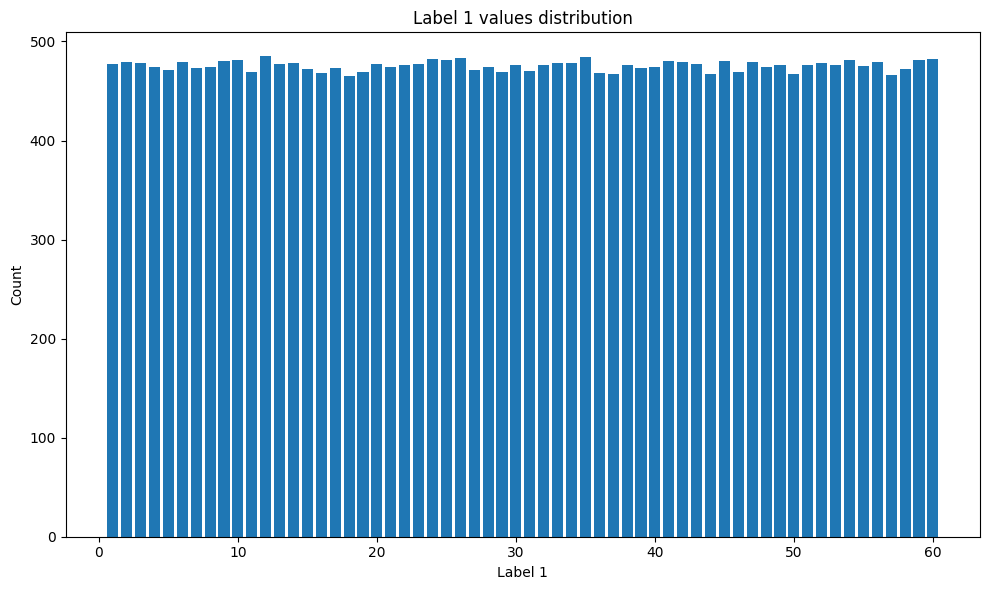

In [13]:
label1_value_counts = y_train['label_1'].value_counts()

plt.figure(figsize=(10, 6))
plt.bar(label1_value_counts.index, label1_value_counts.values)


plt.xlabel('Label 1')
plt.ylabel('Count')
plt.title('Label 1 values distribution')

plt.tight_layout() 
plt.show()

In [16]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [17]:
pca = PCA(n_components=0.95, svd_solver = 'full')
x_train_pca = pca.fit_transform(x_train_scaled)
x_valid_pca = pca.transform(x_valid_scaled)
x_test_pca = pca.transform(x_test_scaled)

In [18]:

scores = []
for model_name, model in getModels().items():
    fold_scores = cross_val_score(model, x_train_pca, y_train['label_1'], cv=3, scoring='accuracy', n_jobs = -1)
    scores.append({
        'model' : model_name,
        'score' : np.mean(fold_scores)
    })  

df = pd.DataFrame(scores, columns = ['model', 'score'])
df

,model,score
0,svm,0.936957
1,random_forest,0.846003
2,logistic_regression,0.944460
3,knn,0.881136


In [19]:
model_data = {
    'svm' : {
        'model':svm.SVC(gamma = 'auto'),
        'params' : {
            'C': [1, 10, 100],
            'kernel': ['rbf', 'linear']}
    },
    'logistic_regression' : {
        'model':LogisticRegression(solver = 'liblinear', multi_class = 'auto'),
        'params' : {
            'C': [1, 10, 100]
        }
    }
}

In [24]:
accuracy_scores = []

for model_name, model_info in model_data.items():
    clf = RandomizedSearchCV(model_info['model'], param_distributions = model_info['params'], n_iter=5, cv=3, scoring='accuracy', random_state=42, n_jobs=-1)
    clf.fit(x_train_pca, y_train['label_1'])
    accuracy_scores.append({
      'model' : model_name,
      'best_score' : clf.best_score_,
      'best_params' : clf.best_params_
})

In [25]:
df_hyp_tuning = pd.DataFrame(accuracy_scores, columns = ['model', 'best_score', 'best_params'])
df_hyp_tuning

,model,best_score,best_params
0,svm,0.943198,"{'kernel': 'linear', 'C': 1}"
1,logistic_regression,0.944460,{'C': 1}


In [26]:
best_model_l1 = LogisticRegression(C=1)
best_model_l1.fit(x_train_pca, y_train['label_1'])

#validation
fold_scores_l1 = cross_val_score(best_model_l1, x_valid_pca, y_valid['label_1'], cv=3, scoring='accuracy', n_jobs = -1)
np.mean(fold_scores_l1)

0.952

In [28]:
y_test_label1 = best_model_l1.predict(x_test_pca)
y_test_label1.shape

(744,)

## **Label 2**

In [29]:
train['label_2'].isnull().sum()

480

In [30]:
valid['label_2'].isnull().sum()

14

In [31]:
train_l2 = train.dropna(subset = ['label_2'])
train_l2['label_2'].isnull().sum()

0

In [32]:
valid_l2 = valid.dropna(subset = ['label_2'])
valid_l2['label_2'].isnull().sum()

0

In [33]:
x_train = train_l2.drop(['label_1', 'label_2', 'label_3', 'label_4'], axis=1)
x_valid = valid_l2.drop(['label_1', 'label_2', 'label_3', 'label_4'], axis=1)
x_test = test.drop(['ID'], axis=1)

y_train = train_l2[['label_1', 'label_2', 'label_3', 'label_4']]
y_valid = valid_l2[['label_1', 'label_2', 'label_3', 'label_4']]

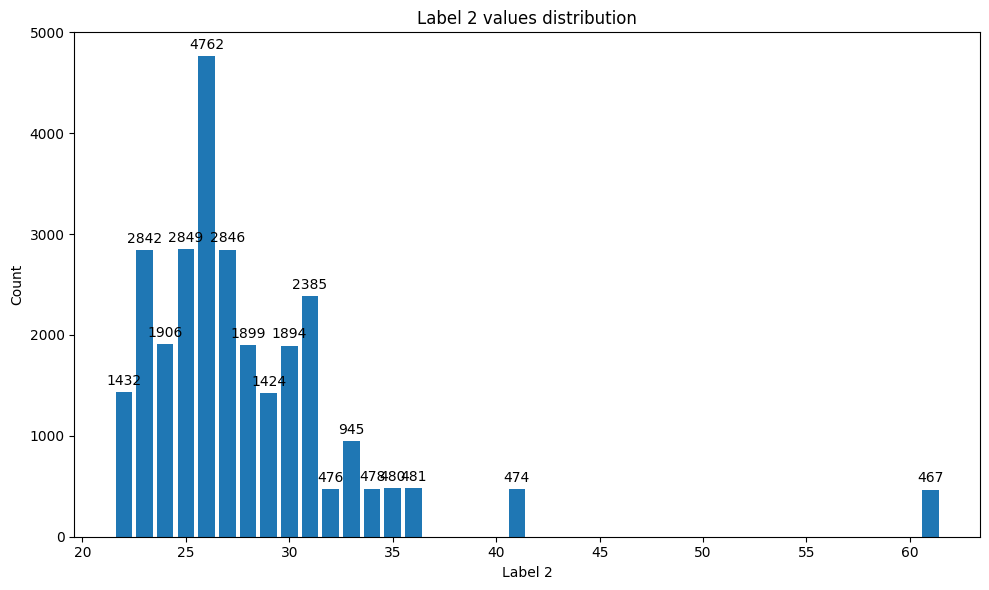

In [34]:
label2_value_counts = y_train['label_2'].value_counts()

plt.figure(figsize=(10, 6))
bars = plt.bar(label2_value_counts.index, label2_value_counts.values)


plt.xlabel('Label 2')
plt.ylabel('Count')
plt.title('Label 2 values distribution')

for bar, count in zip(bars, label2_value_counts.values):
    plt.annotate(str(count), xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                 xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')


plt.tight_layout() 
plt.show()

In [35]:
scaler = RobustScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [36]:
pca = PCA(n_components=0.95, svd_solver = 'full')
x_train_pca = pca.fit_transform(x_train_scaled)
x_val_pca = pca.transform(x_val_scaled)
x_test_pca = pca.transform(x_test_scaled)

In [37]:
scores = []
for model_name, model in getModels().items():
    fold_scores = cross_val_score(model, x_train_pca, y_train['label_2'], cv=3, scoring='accuracy', n_jobs = -1)
    scores.append({
        'model' : model_name,
        'score' : np.mean(fold_scores)
    })  

df_raw = pd.DataFrame(scores, columns = ['model', 'score'])
df_raw

,model,score
0,svm,0.347253
1,random_forest,0.271718
2,logistic_regression,0.305206
3,knn,0.346361


In [38]:
model_data = {
    'svm' : {
        'model':svm.SVC(gamma = 'auto'),
        'params' : {
            'C': [1, 10, 100],
            'kernel': ['rbf', 'linear']}
    },
    'knn' : {
        'model' : KNeighborsClassifier(),
        'params' : {
            'n_neighbors' : list(range(1,5)),
            'p' : [1,2]
        }
    }
}

In [40]:
accuracy_scores = []

for model_name, model_info in model_data.items(): 
    clf = RandomizedSearchCV(model_info['model'], param_distributions = model_info['params'], n_iter=5, cv=3, scoring='accuracy', random_state=42, n_jobs=-1)
    clf.fit(x_train_pca, y_train['label_2'])
    accuracy_scores.append({
      'model' : model_name,
      'best_score' : clf.best_score_,
      'best_params' : clf.best_params_
  })

In [41]:
df_hyp_tuning = pd.DataFrame(accuracy_scores, columns = ['model', 'best_score', 'best_params'])
df_hyp_tuning

,model,best_score,best_params
0,svm,0.362302,"{'kernel': 'rbf', 'C': 10}"
1,logistic_regression,0.306276,{'C': 10}
2,knn,0.365227,"{'p': 1, 'n_neighbors': 1}"


In [42]:
best_model_l2 = KNeighborsClassifier(n_neighbors = 1, p = 2)
best_model_l2.fit(x_train_pca, y_train['label_2'])

#validation
fold_scores_l2 = cross_val_score(best_model_l2, x_val_pca, y_valid['label_2'], cv=3, scoring='accuracy', n_jobs = -1)
np.mean(fold_scores_l2)

0.9116847826086957

In [43]:
y_test_label2 = best_model_l2.predict(x_test_pca)
y_test_label2.shape

array([22., 25., 30., 27., 29., 30., 27., 33., 23., 22., 26., 25., 27.,
       26., 23., 26., 28., 25., 34., 29., 33., 24., 29., 25., 61., 26.,
       28., 23., 25., 26., 23., 30., 30., 24., 28., 33., 24., 25., 26.,
       25., 23., 23., 25., 30., 31., 22., 26., 24., 25., 23., 22., 24.,
       29., 27., 23., 23., 30., 34., 28., 25., 30., 23., 23., 26., 28.,
       25., 25., 25., 22., 32., 33., 26., 61., 30., 23., 31., 26., 31.,
       27., 26., 34., 32., 23., 23., 27., 26., 31., 23., 26., 29., 22.,
       31., 25., 23., 27., 30., 31., 25., 27., 29., 23., 22., 26., 22.,
       24., 36., 26., 26., 32., 25., 27., 27., 26., 24., 30., 24., 26.,
       25., 26., 26., 29., 26., 41., 33., 32., 28., 27., 35., 34., 27.,
       26., 27., 36., 23., 28., 22., 29., 27., 30., 31., 28., 25., 26.,
       31., 23., 30., 30., 26., 33., 30., 29., 27., 23., 24., 31., 30.,
       23., 25., 28., 41., 31., 25., 25., 28., 30., 26., 30., 26., 26.,
       25., 23., 27., 31., 30., 33., 24., 25., 34., 30., 23., 27

### **Label 3**

In [44]:
train['label_3'].isnull().sum()

0

In [45]:
valid['label_3'].isnull().sum()

0

In [46]:
x_train = train.drop(['label_1', 'label_2', 'label_3', 'label_4'], axis=1)
x_valid = valid.drop(['label_1', 'label_2', 'label_3', 'label_4'], axis=1)
x_test = test.drop(['ID'], axis=1)

y_train = train[['label_1', 'label_2', 'label_3', 'label_4']]
y_valid = valid[['label_1', 'label_2', 'label_3', 'label_4']]

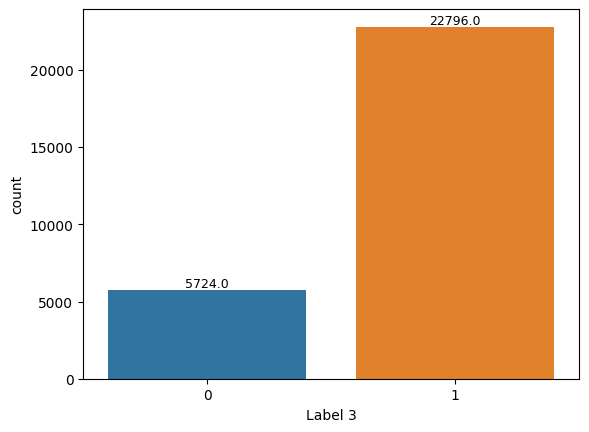

In [47]:
ax = sn.countplot(x=y_train['label_3'])

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=9, color='black')

plt.xlabel('Label 3')

plt.show()

In [48]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [49]:
pca = PCA(n_components=0.95, svd_solver = 'full')
x_train_pca = pca.fit_transform(x_train_scaled)
x_val_pca = pca.transform(x_valid_scaled)
x_test_pca = pca.transform(x_test_scaled)

In [50]:

scores = []
for model_name, model in getModels().items():
    fold_scores = cross_val_score(model, x_train_pca, y_train['label_3'], cv=3, scoring='accuracy', n_jobs = -1)
    scores.append({
        'model' : model_name,
        'score' : np.mean(fold_scores)
    })  

df_raw = pd.DataFrame(scores, columns = ['model', 'score'])
df_raw

,model,score
0,svm,0.976332
1,random_forest,0.880680
2,logistic_regression,0.973141
3,knn,0.925245


In [51]:
model_data = {
    'svm' : {
        'model':svm.SVC(gamma = 'auto'),
        'params' : {
            'C': [1, 10, 100],
            'kernel': ['rbf', 'linear']}
    },
    'logistic_regression' : {
        'model':LogisticRegression(solver = 'liblinear', multi_class = 'auto'),
        'params' : {
            'C': [1, 10, 100]
        }
    }
}

In [52]:
accuracy_scores = []

for model_name, model_info in model_data.items():
  clf = RandomizedSearchCV(model_info['model'], param_distributions = model_info['params'], n_iter=5, cv=3, scoring='accuracy', random_state=42, n_jobs=-1)
  clf.fit(x_train_pca, y_train['label_3'])
  accuracy_scores.append({
      'model' : model_name,
      'best_score' : clf.best_score_,
      'best_params' : clf.best_params_
  })

In [53]:
df_hyp_tuning = pd.DataFrame(accuracy_scores, columns = ['model', 'best_score', 'best_params'])
df_hyp_tuning

,model,best_score,best_params
0,svm,0.970056,"{'kernel': 'linear', 'C': 100}"
1,logistic_regression,0.973141,{'C': 1}


In [54]:
best_model_l3 = svm.SVC(C = 100, kernel = 'rbf')
best_model_l3.fit(x_train_pca, y_train['label_3'])

#validation
fold_scores_l3 = cross_val_score(best_model_l3, x_val_pca, y_valid['label_3'], cv=3, scoring='accuracy', n_jobs = -1)
np.mean(fold_scores_l3)

1.0

In [55]:
y_test_label3 = best_model_l3.predict(x_test_pca)
y_test_label3.shape

array([0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

### **Label 4**

In [56]:
train['label_4'].isnull().sum()

0

In [57]:
valid['label_4'].isnull().sum()

0

In [58]:
x_train = train.drop(['label_1', 'label_2', 'label_3', 'label_4'], axis=1)
x_valid = valid.drop(['label_1', 'label_2', 'label_3', 'label_4'], axis=1)
x_test = test.drop(['ID'], axis=1)

y_train = train[['label_1', 'label_2', 'label_3', 'label_4']]
y_valid = valid[['label_1', 'label_2', 'label_3', 'label_4']]

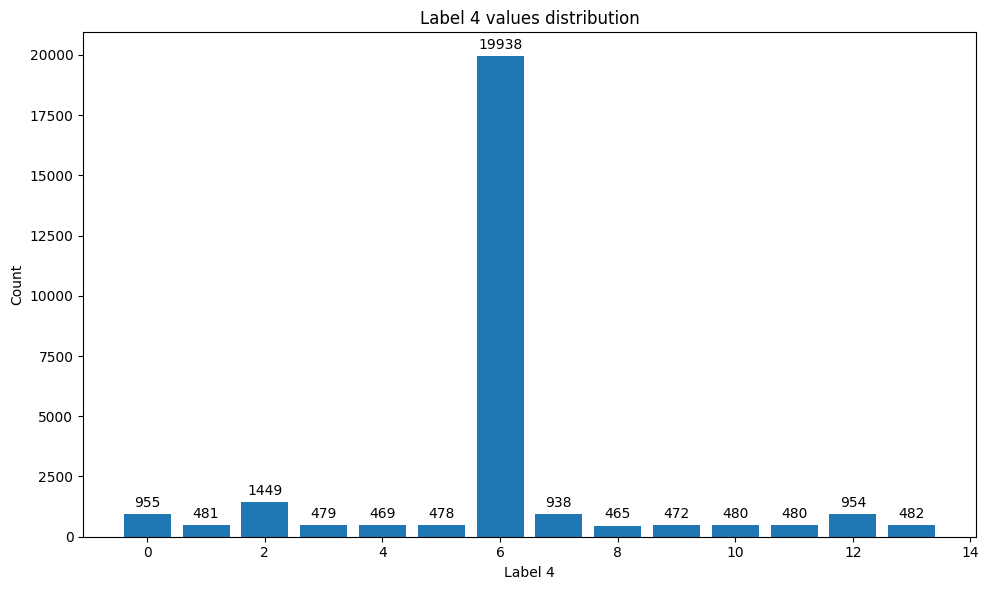

In [59]:
label4_value_counts = y_train['label_4'].value_counts()

plt.figure(figsize=(10, 6))
bars = plt.bar(label4_value_counts.index, label4_value_counts.values)


plt.xlabel('Label 4')
plt.ylabel('Count')
plt.title('Label 4 values distribution')

for bar, count in zip(bars, label4_value_counts.values):
    plt.annotate(str(count), xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                 xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')


plt.tight_layout() 
plt.show()

In [60]:
sampler = RandomOverSampler(random_state=0)
x_train_resampled, y_train_resampled = sampler.fit_resample(x_train, y_train['label_4'])

In [61]:
label4_value_counts = y_train_resampled.value_counts()

plt.figure(figsize=(10, 6))
bars = plt.bar(label4_value_counts.index, label4_value_counts.values)


plt.xlabel('Label 4')
plt.ylabel('Count')
plt.title('Label 4 values distribution after OverSampling')

for bar, count in zip(bars, label4_value_counts.values):
    plt.annotate(str(count), xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                 xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')


plt.tight_layout() 
plt.show()

In [62]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_resampled)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [63]:
pca = PCA(n_components=0.95, svd_solver = 'full')
x_train_pca = pca.fit_transform(x_train_scaled)
x_val_pca = pca.transform(x_valid_scaled)
x_test_pca = pca.transform(x_test_scaled)

In [64]:
scores = []
for model_name, model in getModels().items():
    fold_scores = cross_val_score(model, x_train_pca, y_train_resampled['label_4'], cv=3, scoring='accuracy', n_jobs = -1)
    scores.append({
        'model' : model_name,
        'score' : np.mean(fold_scores)
    }) 

df_raw = pd.DataFrame(scores, columns = ['model', 'score'])
df_raw

,model,score
0,svm,0.887237
1,random_forest,0.714586
2,logistic_regression,0.823878
3,knn,0.817530


In [65]:
model_data = {
    'svm' : {
        'model':svm.SVC(gamma = 'auto'),
        'params' : {
            'C': [1, 10, 100],
            'kernel': ['rbf', 'linear']}
    },
    'logistic_regression' : {
        'model':LogisticRegression(solver = 'liblinear', multi_class = 'auto'),
        'params' : {
            'C': [1, 10, 100]
        }
    },
    'knn' : {
        'model' : KNeighborsClassifier(),
        'params' : {
            'n_neighbors' : list(range(1,5)),
            'p' : [1,2]
        }
    }
}

In [66]:
accuracy_scores = []

for model_name, model_info in model_data.items():
  clf = RandomizedSearchCV(model_info['model'], param_distributions = model_info['params'], n_iter=5, cv=3, scoring='accuracy', random_state=42, n_jobs=-1)
  clf.fit(x_train_pca, y_train_resampled['label_4'])
  accuracy_scores.append({
      'model' : model_name,
      'best_score' : clf.best_score_,
      'best_params' : clf.best_params_
  })

In [67]:
df_hyp_tuning = pd.DataFrame(accuracy_scores, columns = ['model', 'best_score', 'best_params'])
df_hyp_tuning

,model,best_score,best_params
0,svm,0.899930,"{'kernel': 'rbf', 'C': 10}"
1,logistic_regression,0.823878,{'C': 1}
2,knn,0.801717,"{'p': 2, 'n_neighbors': 4}"


In [68]:
best_model_l4 = svm.SVC(C = 100, kernel = 'rbf')
best_model_l4.fit(x_train_pca, y_train_resampled)

#validation
fold_scores_l4 = cross_val_score(best_model_l4, x_val_pca, y_valid['label_4'], cv=3, scoring='accuracy', n_jobs = -1)
np.mean(fold_scores_l4)

NameError: name 'y_train_resampled' is not defined

In [ ]:
y_test_label4 = best_model_l4.predict(x_test_pca)
y_test_label4.shape

In [ ]:
final_df = test[['ID']]
final_df['label_1'] = y_test_label1
final_df['label_2'] = y_test_label2
final_df['label_3'] = y_test_label3
final_df['label_4'] = y_test_label4

In [ ]:
final_df.to_csv('Outputs/Layer-10/solutions_layer10.csv', index=False)